In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications import  ResNet50V2
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


# Task 1

## Collecting the data

In [36]:
data_list = []

labels = {r'C:\Users\noorz\Documents\Year 2\Big Data\data\water' : 'Water',
          r'C:\Users\noorz\Documents\Year 2\Big Data\data\desert' : 'Desert',
          r'C:\Users\noorz\Documents\Year 2\Big Data\data\cloudy' : 'Cloudy',
          r'C:\Users\noorz\Documents\Year 2\Big Data\data\green_area' : 'Green_Area',}


In [37]:

# Loop over the train, test, and val folders and extract the image path and label
for folder in labels:
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        label = labels[folder]
        data_list.append({'image_path': image_path, 'label': label})


In [38]:
data = pd.DataFrame(data_list)
data.head(10)

,image_path,label
0,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
1,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
2,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
3,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
4,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
5,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
6,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
7,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
8,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
9,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water


In [39]:
# Save the data to a CSV file
data.to_csv('image_dataset.csv', index=False)

In [40]:
df = pd.read_csv(r"C:\Users\noorz\Documents\Year 2\Big Data\image_dataset.csv")

In [41]:
df

,image_path,label
0,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
1,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
2,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
3,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
4,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Water
...,...,...
5626,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Green_Area
5627,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Green_Area
5628,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Green_Area
5629,C:\Users\noorz\Documents\Year 2\Big Data\data\...,Green_Area


## Data Visualization

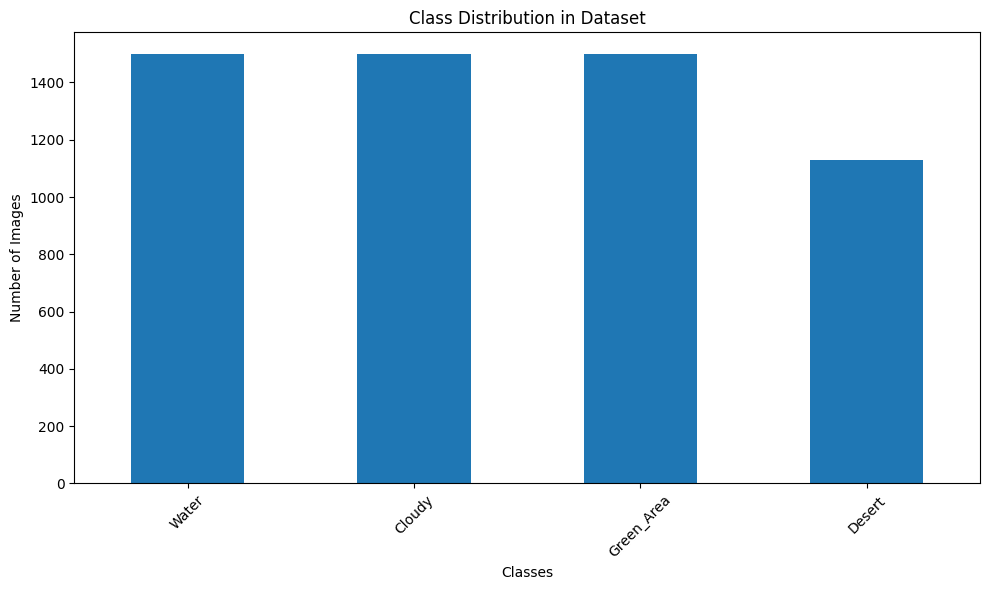

In [42]:
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model Selection and Training

In [43]:
label_map = {'Cloudy': 0, 'Desert': 1, 'Green_Area': 2, 'Water': 3}

In [65]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [66]:
def load_images_and_labels(df, img_size=(128, 128)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = image.load_img(row['image_path'], target_size=img_size)
        img_array = image.img_to_array(img)
        images.append(img_array)
        labels.append(label_map[row['label']])
    return np.array(images), to_categorical(labels, num_classes=len(label_map))


In [67]:
train_images, train_labels = load_images_and_labels(train_df, img_size=(128, 128))
test_images, test_labels = load_images_and_labels(test_df, img_size=(128, 128))

# Normalise images
train_images = train_images / 255.0
test_images = test_images / 255.0

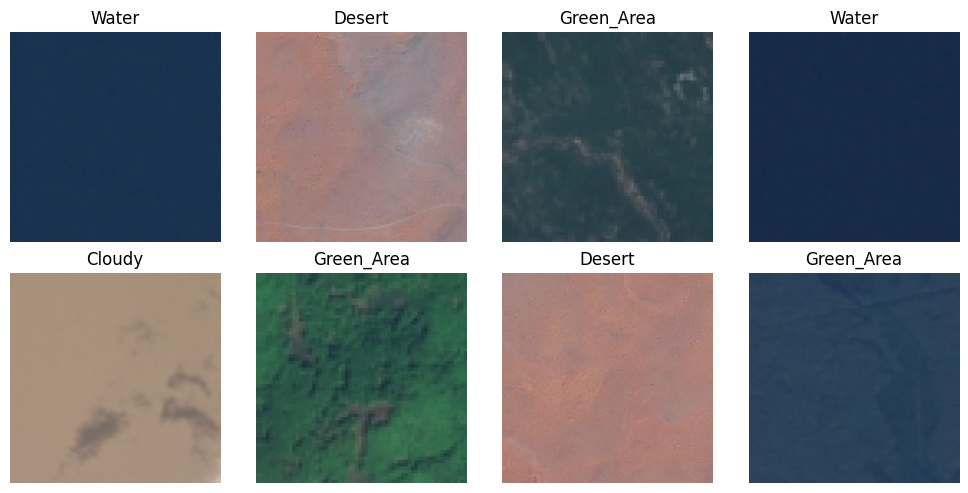

In [68]:
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(train_images[i])
    plt.title(list(label_map.keys())[np.argmax(train_labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Augmentation

In [72]:

# Pre-process the data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.8, 1.2],
                                   channel_shift_range=30,
                                   rotation_range=45,
                                   vertical_flip=True,
                                   fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    target_size=(128, 128),
                                                    batch_size=32,
                                                    class_mode="categorical")

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(128, 128),
                                                  batch_size=32,
                                                  class_mode="categorical")

Found 4504 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.


In [73]:
# Get number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class indices: {train_generator.class_indices}")


Number of classes: 4
Class indices: {'Cloudy': 0, 'Desert': 1, 'Green_Area': 2, 'Water': 3}


## Model

In [80]:

# Build CNN model for 4-class image classification
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Fourth Convolutional Block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 classes: Cloudy, Desert, Green_Area, Water
])

# Compile the model with appropriate loss function and optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For multi-class classification with one-hot encoded labels
    metrics=['accuracy', 'top_2_accuracy']
)

# Display model architecture
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,241,796 (20.00 MB)

 Trainable params: 5,240,836 (19.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [83]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use categorical_crossentropy for categorical labels
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

history = model.fit(
    train_generator,
    epochs=5,  # You can adjust this
    validation_data=test_generator,  # Use test_generator for validation if you don't have a separate val set
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)


Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6210 - loss: 3.2949 - precision: 0.6264 - recall: 0.6176 - val_accuracy: 0.2804 - val_loss: 1.3735 - val_precision: 0.5932 - val_recall: 0.0621
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6618 - loss: 1.4250 - precision: 0.6647 - recall: 0.6547 - val_accuracy: 0.5191 - val_loss: 0.8549 - val_precision: 0.6098 - val_recall: 0.2981
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.6817 - loss: 0.9068 - precision: 0.6861 - recall: 0.6620 - val_accuracy: 0.6815 - val_loss: 0.5952 - val_precision: 0.7733 - val_recall: 0.6628
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7353 - loss: 0.6288 - precision: 0.7412 - recall: 0.7210 - val_accuracy: 0.7746 - val_loss: 0.5683 - val_precision: 0.7834 - val_recall: 0.7445
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 138s 973ms/step - accuracy: 0.7259 - loss: 0.6166 - precision: 0.7336 - recall: 0.7040 - val_accuracy: 0.8394 - val_loss:

## Evaluation and Optimisation

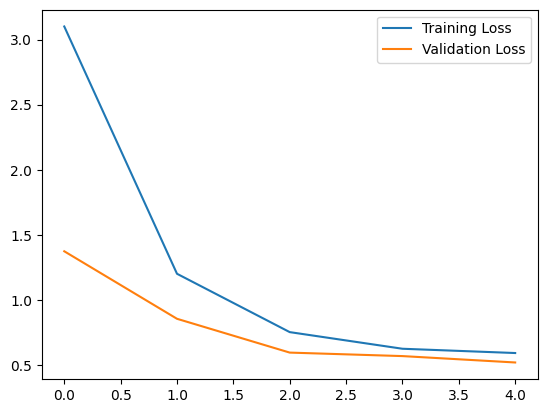

<Figure size 640x480 with 0 Axes>

In [85]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

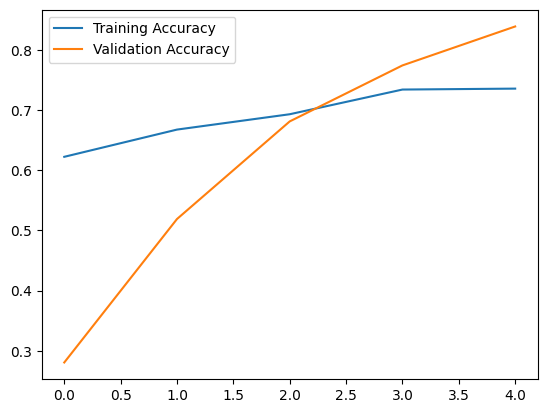

<Figure size 640x480 with 0 Axes>

In [86]:
# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step


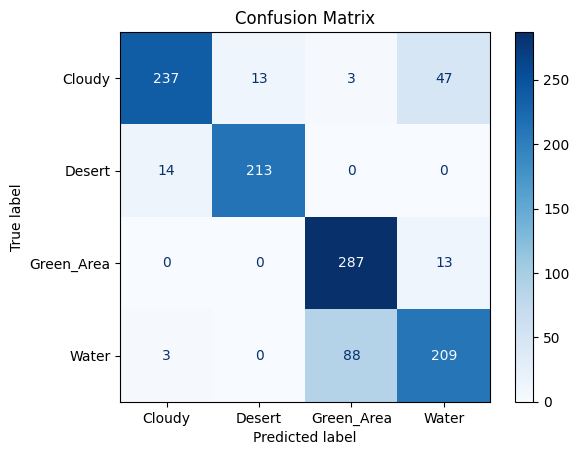

In [89]:
# Predict class probabilities
y_pred_probs = model.predict(test_images)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [90]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=list(label_map.keys()))
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Cloudy       0.93      0.79      0.86       300
      Desert       0.94      0.94      0.94       227
  Green_Area       0.76      0.96      0.85       300
       Water       0.78      0.70      0.73       300

    accuracy                           0.84      1127
   macro avg       0.85      0.85      0.84      1127
weighted avg       0.85      0.84      0.84      1127



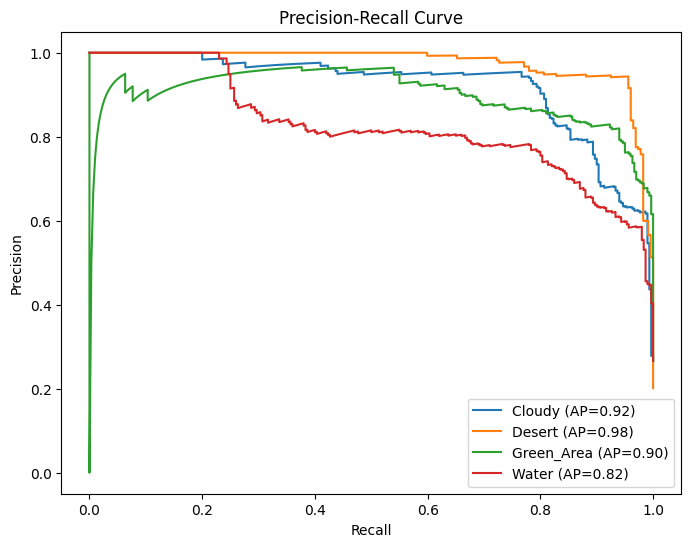

In [91]:
n_classes = len(label_map)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"{list(label_map.keys())[i]} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [95]:
# Setup training callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7800 - loss: 0.5074 - precision: 0.7832 - recall: 0.7607 - val_accuracy: 0.5964 - val_loss: 1.0259 - val_precision: 0.5917 - val_recall: 0.5848 - learning_rate: 0.0010
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7500 - loss: 0.3623 - precision: 0.7500 - recall: 0.7500 - val_accuracy: 0.5991 - val_loss: 1.0171 - val_precision: 0.5951 - val_recall: 0.5866 - learning_rate: 0.0010
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.7648 - loss: 0.5671 - precision: 0.7706 - recall: 0.7565 - val_accuracy: 0.7554 - val_loss: 0.5483 - val_precision: 0.7547 - val_recall: 0.7527 - learning_rate: 0.0010
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8438 - loss: 0.4311 - precision: 0.8387 - recall: 0.8125 - val_accuracy: 0.8045 - val_loss: 0.4966 - val_precision: 0.8047 - val_recall: 0.8018 - learning_rate: 0.0010
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 

## Implementation and Discussion

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step


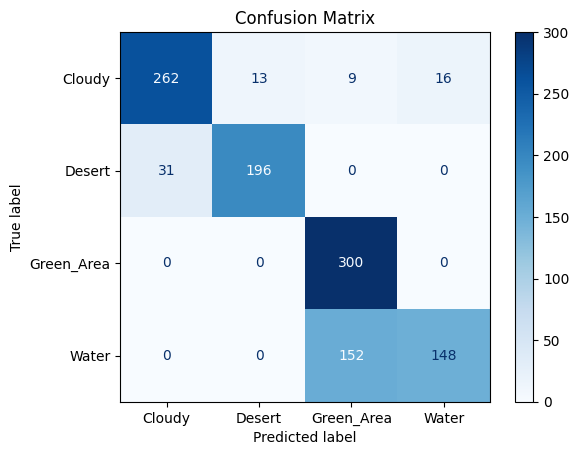

Classification Report:
               precision    recall  f1-score   support

      Cloudy       0.89      0.87      0.88       300
      Desert       0.94      0.86      0.90       227
  Green_Area       0.65      1.00      0.79       300
       Water       0.90      0.49      0.64       300

    accuracy                           0.80      1127
   macro avg       0.85      0.81      0.80      1127
weighted avg       0.84      0.80      0.80      1127



In [ ]:

# Predict class probabilities for the test set
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=list(label_map.keys()))
print("Classification Report:\n", report)

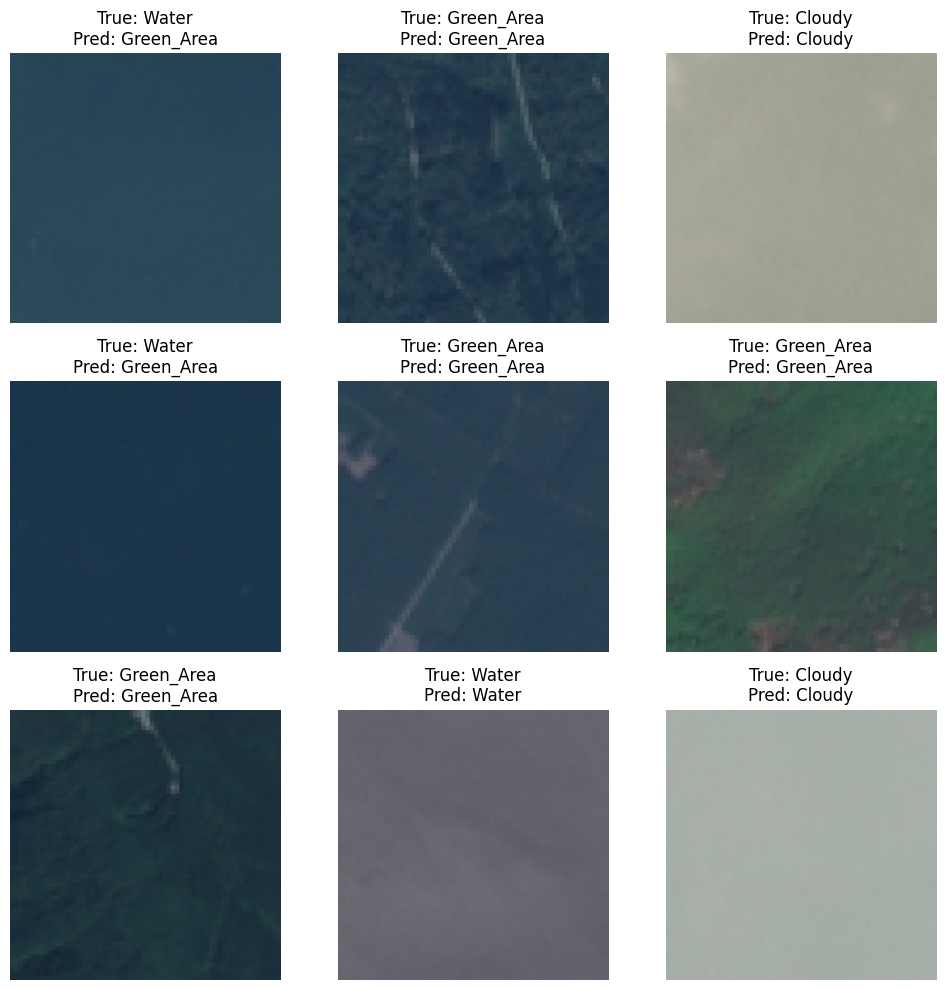

In [98]:
# Plotting the predictions of model
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {list(label_map.keys())[y_true[i]]}\nPred: {list(label_map.keys())[y_pred[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Improved Model

In [104]:
# Load ResNet50V2 base model with pretrained ImageNet weights, exclude top layers
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()
# Train the model
history = model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,759,748 (105.90 MB)

 Trainable params: 4,194,948 (16.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 137s 859ms/step - accuracy: 0.8586 - loss: 0.4904 - val_accuracy: 0.9636 - val_loss: 0.1168
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 118s 833ms/step - accuracy: 0.9546 - loss: 0.1289 - val_accuracy: 0.9698 - val_loss: 0.1104
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 119s 842ms/step - accuracy: 0.9737 - loss: 0.1006 - val_accuracy: 0.9689 - val_loss: 0.1194
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 118s 834ms/step - accuracy: 0.9717 - loss: 0.1180 - val_accuracy: 0.9752 - val_loss: 0.0959
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 129s 914ms/step - accuracy: 0.9768 - loss: 0.0748 - val_accuracy: 0.9752 - val_loss: 0.1205


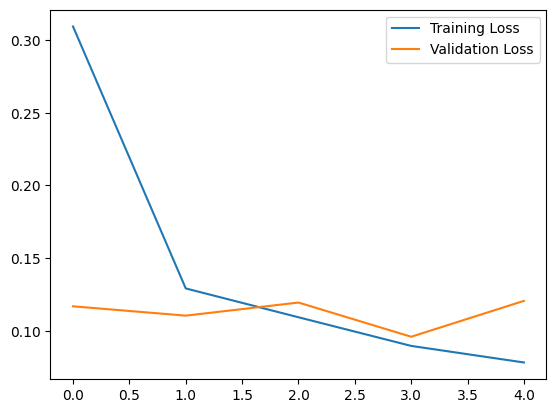

<Figure size 640x480 with 0 Axes>

In [105]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

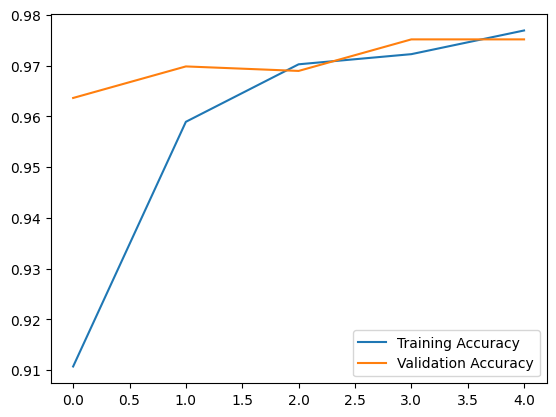

<Figure size 640x480 with 0 Axes>

In [106]:
# Plot the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 826ms/step


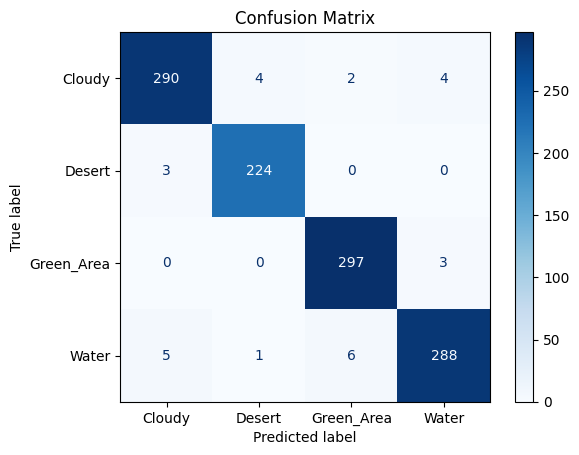

In [107]:
# Predict class probabilities
y_pred_probs = model.predict(test_images)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [108]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=list(label_map.keys()))
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Cloudy       0.97      0.97      0.97       300
      Desert       0.98      0.99      0.98       227
  Green_Area       0.97      0.99      0.98       300
       Water       0.98      0.96      0.97       300

    accuracy                           0.98      1127
   macro avg       0.98      0.98      0.98      1127
weighted avg       0.98      0.98      0.98      1127



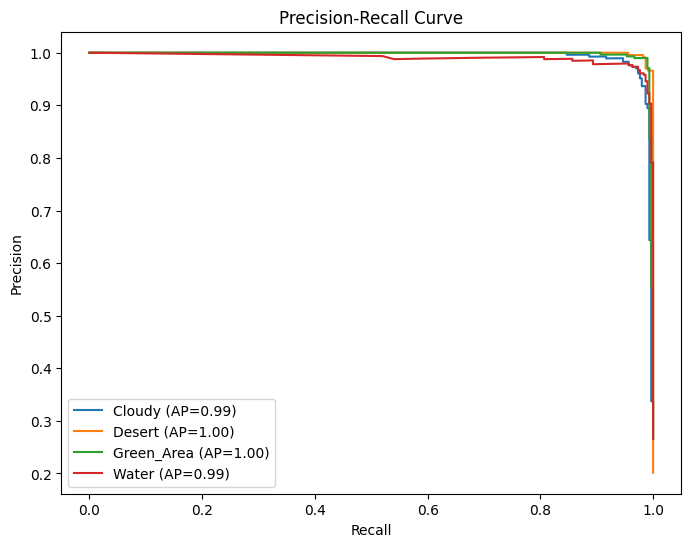

In [109]:
n_classes = len(label_map)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f"{list(label_map.keys())[i]} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

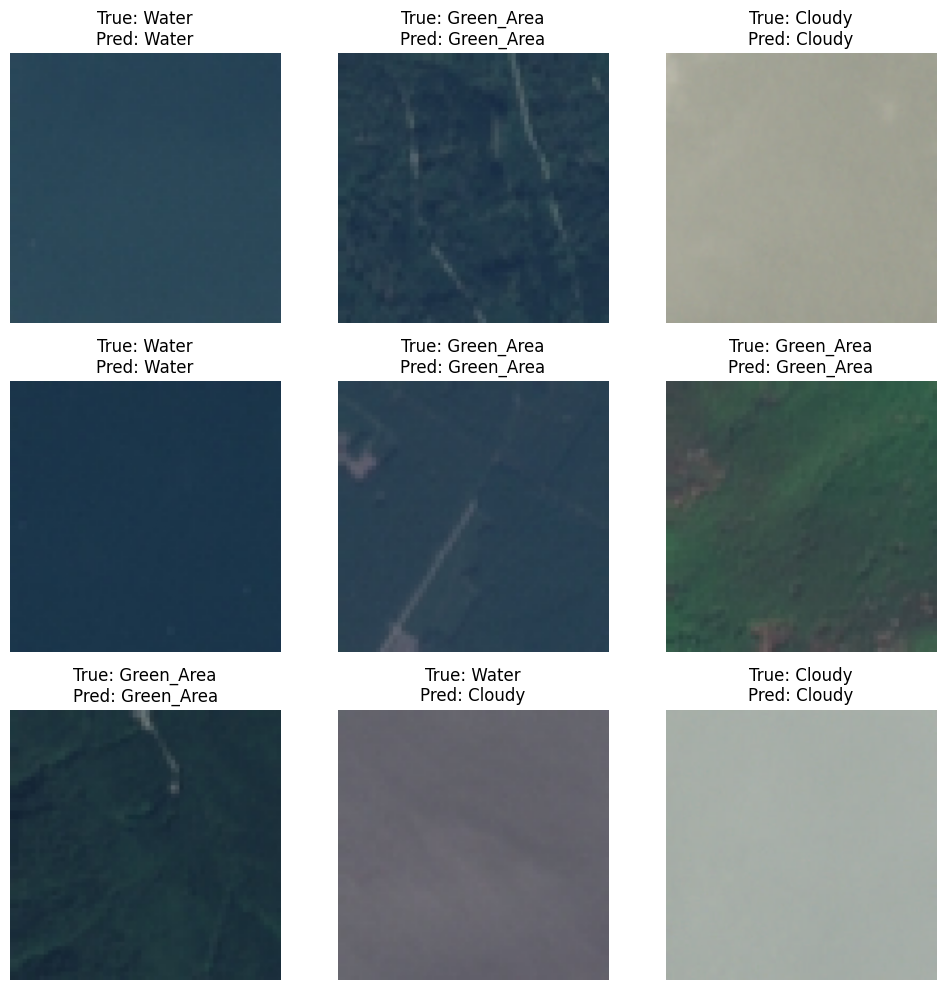

In [110]:
# Plotting the predictions of model
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {list(label_map.keys())[y_true[i]]}\nPred: {list(label_map.keys())[y_pred[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()